<a href="https://colab.research.google.com/github/LM1997610/DMT/blob/main/HW_3_DMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DMT 2023 - Homework 3

## Group composition:

------------YOUR TEXT STARTS HERE------------

<br>

Mazzucco, Luca: 1997610

Zilviano, Paolo: 1916518


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

## Homework 3
The homework consists of two parts:

  1. Dimensionality Reduction

  2. Supervised Learning

> Ensure that the notebook can be faithfully reproduced by anyone (hint: pseudo random number generation).

> If you need to set a random seed, set it to `160`.

# Part 1
In this part of the homework, you have to deal with Dimensionality Reduction.

Import **ALL** the Python packages that you need for Part 1.

In [ ]:
#REMOVE_OUTPUT#
%%capture
!pip install --upgrade --no-cache-dir gdown

#YOUR CODE STARTS HERE#

import numpy as np
import pandas as pd
import re

import nltk; nltk.download('stopwords'), nltk.download('punkt')
import gensim 

from tqdm.auto import tqdm
from tabulate import tabulate
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt

#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

## Part 1.1
The data you need to process comes from the book *Le Morte D'Arthur* by Thomas Malory.

You have to carry out Topic Modeling on book chapters.

The goal is to achieve a topic division within the following limits:

- The total computation may not exceed 10 minutes (starting from Part 1.1.5; Parts 1.1.1 to 1.1.4 are not considered for time calculation)
- The division into topics must be the "best one"

### 1.1.1
Download the data from the Drive link (code already provided).

In [ ]:
#REMOVE_OUTPUT#
!gdown 1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
!gdown 1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut

Downloading...
From: https://drive.google.com/uc?id=1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html
100% 964k/964k [00:00<00:00, 671MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html
100% 1.10M/1.10M [00:00<00:00, 681MB/s]


### 1.1.2
Parse the HTML. **Part** of code already provided: follow the comments to complete the code.


In [ ]:
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html') as fp:
    vol1 = bs(fp, 'html.parser')
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html') as fp:
    vol2 = bs(fp, 'html.parser')

def clean_text(txt):
    words_to_put_space_before = [".",",",";",":","’","'"]
    words_to_lowercase = ["First","How","Some","Yet","Of","A","The","What","Fifth"]
    
    app = txt.replace("\n"," ")
    for word in words_to_put_space_before:
        app = app.replace(word," "+word)
    for word in words_to_lowercase:
        app = app.replace(word+" ",word.lower()+" ")
    return app.strip()

def parse_html(soup):
    titles = []
    texts = []
    for chapter in soup.find_all("h3"):
        chapter_title = chapter.text
        if "CHAPTER" in chapter_title:
            chapter_title = clean_text("".join(chapter_title.split(".")[1:]))
            titles.append(chapter_title)
            
            chapter_text = [p.text for p in chapter.findNextSiblings("p")]
            chapter_text = clean_text(" ".join(chapter_text))
            texts.append(chapter_text)
    return titles, texts

In [ ]:
#YOUR CODE STARTS HERE#
#Extract all the chapters' titles and texts from the two volumes


titles_1, texts_1 = parse_html(vol1)
titles_2, texts_2 = parse_html(vol2)


#Transform the list into a pandas DataFrame.

num_doc = [str(i).zfill(1) for i in range(1,len(titles_1 + titles_2)+1)]


df = pd.DataFrame(zip(num_doc, titles_1+titles_2, texts_1+texts_2), 
                  columns=["docno", 'Titles', 'Texts'])

print("\n df.shape :", df.shape)

#YOUR CODE ENDS HERE#
#THIS IS LINE 20#


 df.shape : (503, 3)


Print the last 8 rows of the DataFrame.

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#

a_table = df[["Titles", "Texts"]].apply(lambda x: x.str[:25]+"...").tail(8)

print()
print(tabulate(a_table, headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print()

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


                Titles                        Texts
---  ----------------------------  ----------------------------
495  how Sir Bedivere found hi...  Then was Sir Bedivere gla...
496  of the opinion of some me...  yet some men say in many ...
497  how when Sir Lancelot hea...  And when he heard in his ...
498  how Sir Launcelot departe...  Then came Sir Bors de Gan...
499  how Sir Launcelot came to...  But sithen I find you thu...
500  how Sir Launcelot went wi...  Then Sir Launcelot rose u...
501  how Sir Launcelot began t...  Then Sir Launcelot never ...
502  how Sir Ector found Sir L...  And when Sir Ector heard ...



<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.3
Extract character's names from the **titles** only. **Part** of code already provided: follow the comments to complete the code.

In [ ]:
all_characters = set()

def extract_character_names_from_string(string_to_parse):

    special_tokens = ["of","the","le","a","de"]
    remember = ""
    last_is_special_token = False

    tokens = string_to_parse.split(" ")
    characters_found = set()

    for i,word in enumerate(tokens):

        if word[0].isupper() or (remember!="" and word in special_tokens):
            word = word.replace("'s","").replace("’s","")
            last_is_special_token = False
            if remember!="":
                if word in special_tokens:
                    last_is_special_token = True
                remember = remember+" "+word
            else: remember = word
        else:
            if remember!="":
                if last_is_special_token:
                    for tok in special_tokens:
                        remember = remember.replace(" "+tok,"")
                characters_found.add(remember)
            remember = ""
            last_is_special_token = False
    return characters_found

#all_characters = set([x for x in all_characters if x[-2:]!="'s"])

In [ ]:
#YOUR CODE STARTS HERE#
#Extract all characters' names

all_characters = df["Titles"].apply(extract_character_names_from_string)
#all_characters = set([x for x in all_characters if x[-2:]!="'s"])
all_characters = set.union(*map(set, all_characters)) 


#YOUR CODE ENDS HERE#
#THIS IS LINE 15#

Print the names of all the knights (i.e. characters with `Sir` in their name).

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#



knights={person for person in all_characters if person.lower().find("sir")>-1}
print("knights:", knights, sep=" ")


#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

knights: {'Sir Alisander', 'Sir Sadok', 'Sir Breunor', 'Sir Marhaus', 'Sir Blamore', 'Sir Pelleas', 'Sir Turquine', 'Sir Anguish', 'Sir Elias', 'Sir Carados', 'Sir Galihodin', 'Sir Dagonet', 'Sir Lanceor', 'Sir Gaheris', 'Sir Mador', 'Sir Accolon', 'Sir Tristram', 'Sir Pervivale', 'Sir Tor', 'Sir Beaumains', 'Sir Percivale', 'Sir Archade', 'Sir Breuse Saunce Pité', 'Sir Palomides', 'Sir Tristram de Liones', 'Sir Lavaine', 'Sir Agravaine', 'Sir Safere', 'Sir Berluse', 'Sir Urre', 'Sir Malgrin', 'Sir Persant', 'Sir Uriens', 'Sir Gawaine', 'Sir Aglovale', 'Sir Lionel', 'Sir Colgrevance', 'Sir Lamorak', 'Sir Ector', 'Sir Nabon', 'Sir Accolon of Gaul', 'Sir Gareth', 'Sir Frol', 'Sir Dinadan', 'Sir Lancelot', 'Sir Sagramore le Desirous', 'Sir Belliance', 'Sir Galahad', 'Sir Suppinabiles', 'Sir Bedivere', 'Sir Galahalt', 'Sir Epinogris', 'Sir Pedivere', 'Sir Brian', 'Sir Bleoberis', 'Sir Bors', 'Sir Persant of Inde', 'Sir Segwarides', 'Sir Launcelot', 'Sir Bliant', 'Sir Amant', 'Sir Mordred',

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.4
Preprocess the data

> Consider only the titles

> Each document must be a list of terms

> Discard documents that have less than 10 (non-unique) terms before the preprocessing

> After preprocessing, each document must be represented by at least 5 tokens

- Several preprocessing options are possible



In [ ]:
#YOUR CODE STARTS HERE#

def preprocess_data(doc_set, terms_b4_prepr, n_t_after, token_min_length=1):
    # create English stop words list
    en_stop = set(nltk.corpus.stopwords.words('english'))
    # create p_stemmer of class PorterStemmer
    p_stemmer = nltk.stem.porter.PorterStemmer()            
    processed_tokenized_texts = []
    print("\nstart preprocessing data :\n")

    for n,text in enumerate(doc_set):   # loop through document list
        lowercase_text = text.lower()
        pattern = re.compile(r'[^a-z]+')
        # clean text: replace pattern with space
        cleaned_text = pattern.sub(' ', lowercase_text).strip() 
        tokenized_text = cleaned_text.split(" ")  # divide text in tokens
        if len(tokenized_text) >= terms_b4_prepr: # remove stop words from tokens
            stopped_tokens = [token for token in tokenized_text if token not in en_stop]
            if token_min_length>1: # remove very small words, length < 3
                meaningful_tokens = [token for token in stopped_tokens if len(token) >= token_min_length] 
            else:
                meaningful_tokens = stopped_tokens
            stemmed_tokens = [p_stemmer.stem(token) for token in meaningful_tokens] # stem tokens
            
            processed_tokenized_texts.append(stemmed_tokens)  # add tokens to list 
           
          
        else:
            print(" doc: {} → not enough terms...".format(n, len(tokenized_text)))
    
    # discard documents with less than 5 tokens
    doc_list = [x for x in processed_tokenized_texts if len(x) >= n_t_after]
    
    print("\nn_of_docs: ", len(doc_list),"\n")
    return doc_list

terms_before_preprocessing, min_tokens_after_preprocess = 10, 5

docs =  preprocess_data(df.Titles, terms_before_preprocessing, min_tokens_after_preprocess)

#YOUR CODE ENDS HERE#
#THIS IS LINE 40#


start preprocessing data :

 doc: 3 → not enough terms...
 doc: 5 → not enough terms...
 doc: 14 → not enough terms...
 doc: 15 → not enough terms...
 doc: 30 → not enough terms...
 doc: 69 → not enough terms...
 doc: 108 → not enough terms...
 doc: 146 → not enough terms...
 doc: 147 → not enough terms...
 doc: 285 → not enough terms...
 doc: 309 → not enough terms...
 doc: 393 → not enough terms...
 doc: 413 → not enough terms...
 doc: 454 → not enough terms...

n_of_docs:  483 



Print the documents where the (preprocessed) term `Bedivere` appears.

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#

word = "Bedivere"
preprocessed_word = nltk.stem.porter.PorterStemmer().stem(word)
doc_id, tok_list = [(n,x) for n,x in enumerate(docs) if preprocessed_word in x][0]

print("document_ID: {} -> {}".format(doc_id, tok_list))

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

document_ID: 475 -> ['sir', 'bediver', 'found', 'morrow', 'dead', 'hermitag', 'abod', 'hermit']


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

### 1.1.5
Build a dictionary of the terms in the documents.

In [ ]:
#YOUR CODE STARTS HERE#


dictionary = gensim.corpora.Dictionary(docs)

print(dictionary)


#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

Dictionary<847 unique tokens: ['cornwal', 'depart', 'duke', 'first', 'igrain']...>


Print out the 5 most common terms

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#

terms = dictionary.most_common(5)
result = ' , '.join(["'"+str(i[0])+"' : "+str(i[1]) for i in terms]).split(" , ")

print("Top 5 most common terms :\n", *result, sep="\n")

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

Top 5 most common terms :

'sir' : 589
'king' : 173
'launcelot' : 148
'tristram' : 130
'knight' : 127


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

### 1.1.6
Perform a document-term encoding of the dataset.

- Several encodings are possible

In [ ]:
#YOUR CODE STARTS HERE#

# Converting list of documents (corpus) 
# into Document Term Matrix using dictionary.

doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]


#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

Print out the sparsity of the matrix

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#

matrix = gensim.matutils.corpus2dense(doc_term_matrix, num_terms = len(dictionary))
print("matrix.shape :", matrix.shape)

sparsity = 1.0 - np.count_nonzero(matrix) / matrix.size  # sparsity
print("\nsparsity :", round(sparsity,4))

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

matrix.shape : (847, 483)

sparsity : 0.9894


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

### 1.1.7
Perform Latent Semantic Analysis for at least 5 different numbers of topics.

In [ ]:
#YOUR CODE STARTS HERE#

models_list = []

possible_numbers_of_topics = [2,3,4,5,6,8,10,12,15,20,25]

for number_of_topics in tqdm(possible_numbers_of_topics):

  # train model
  lsa_model = gensim.models.LsiModel(doc_term_matrix, num_topics=number_of_topics, 
                                    id2word = dictionary, random_seed=160)
  models_list.append(lsa_model)

#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

  0%|          | 0/11 [00:00<?, ?it/s]

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.8
For each of the calculations above, calculate a measure of the "goodness" of the division into topics.

In [ ]:
#YOUR CODE STARTS HERE#


coherence_values = []

for each_model in tqdm(models_list):

  coherence_model = gensim.models.CoherenceModel(model=each_model, texts=docs,
                                                 dictionary=dictionary, coherence='c_v')
  
  coherence_values.append(coherence_model.get_coherence())


#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

  0%|          | 0/11 [00:00<?, ?it/s]

Plot the measure as the number of topics varies.

[comment]: <> (#SHOW_CELL#)

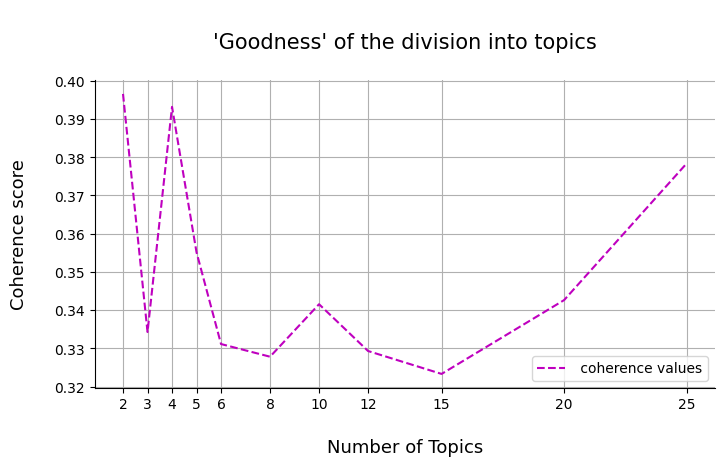

In [ ]:
#YOUR CODE STARTS HERE#

print()
plt.figure(figsize=(8,4))
plt.plot(possible_numbers_of_topics, coherence_values,"--m", label=" coherence values")
plt.xticks(possible_numbers_of_topics)

plt.title("\n'Goodness' of the division into topics\n",fontsize=15)

plt.xlabel("\nNumber of Topics", fontsize=13)
plt.ylabel("Coherence score\n", fontsize=13)
plt.legend(loc="lower right")

ax = plt.subplot(111)
ax.spines[['right', 'top']].set_visible(False)
plt.grid()
plt.show();

#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

Which number of topics is the "best" to model this dataset?

**Use at most 2 sentences.**

[comment]: <> (#SHOW_CELL#)

----------YOUR TEXT STARTS HERE----------

<br>

The number of topics that best represent the model is **two** or **four**: higher coherence scores.\
Measure of consistency among topics.


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

### 1.1.9
Print the 10 most important words for the 5 most important topics.

In [ ]:
#YOUR CODE STARTS HERE#

n_most_significant_topics = 5
n_words = 3

for topic_i, w_and_i in lsa_model.print_topics(num_topics= n_most_significant_topics, 
                                                            num_words = n_words):
    print("TOPIC:", topic_i+1)
    for app in w_and_i.split(" + "):
        value,token = app.split("*")
        value = float(value)
        token = str(token.replace('"',""))
        print("\t",value,token)
    print()
    
#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

TOPIC: 1
	 0.908 sir
	 0.205 tristram
	 0.199 launcelot
	 0.138 king
	 0.095 palomid
	 0.09 knight
	 0.074 arthur
	 0.073 came
	 0.062 gawain
	 0.06 fought

TOPIC: 2
	 -0.78 king
	 -0.49 arthur
	 0.196 sir
	 -0.168 knight
	 -0.125 came
	 -0.123 mark
	 -0.082 made
	 0.052 tristram
	 -0.046 great
	 -0.044 merlin

TOPIC: 3
	 0.532 tristram
	 -0.508 knight
	 -0.473 launcelot
	 0.189 king
	 -0.149 queen
	 0.148 palomid
	 0.133 isoud
	 -0.132 came
	 0.101 beal
	 0.09 mark

TOPIC: 4
	 0.688 knight
	 0.416 tristram
	 -0.356 launcelot
	 0.178 fought
	 0.137 ladi
	 -0.125 king
	 -0.108 arthur
	 -0.107 sir
	 0.093 slew
	 0.083 two

TOPIC: 5
	 -0.61 launcelot
	 -0.463 tristram
	 0.206 sir
	 -0.205 queen
	 0.18 gawain
	 -0.167 isoud
	 0.165 came
	 -0.154 made
	 -0.14 la
	 0.136 met



Explain how you selected the 5 most important topics.

**Use at most 1 sentence.**

[comment]: <> (#SHOW_CELL#)

----------YOUR TEXT STARTS HERE----------

<br>

Five most important topics selected through the `print_topics()` function\
from the **models.LsiModel** module (SVD decomposition)

Try to give an explanation of the topic division you obtained.

**Use at most 2 sentences.**

[comment]: <> (#SHOW_CELL#)

----------YOUR TEXT STARTS HERE----------

<br>

The division into topics obtained reflects the importance of the characters.\
For example Launcelot and Tristram absolute protagonists of topic 1,\
while king Arthur of topic 2.




<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

## Part 1.2

### 1.2.1
Suppose you have a dataset with $N$ samples and $M$ features.

You only have $B$ units of memory available on your storage medium.

Assume further that each feature occupies a constant number $b$ of memory units and that this cannot be changed (e.g. you cannot change the precision of floats).

Assuming that the entire dataset cannot fit on your storage medium, how would you accommodate all N samples while retaining as much information about your data as possible?

**Use at most 3 sentences.**

----------YOUR TEXT STARTS HERE----------


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

# Part 2
In this part, your goal is to obtain the best classification on a dataset according to a metric specified in each section.

Import here **ALL** the Python packages that you need for Part 2.

In [ ]:
#REMOVE_OUTPUT#
#YOUR CODE STARTS HERE#

import time; import datetime
import warnings; warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

#YOUR CODE ENDS HERE#
#THIS IS LINE 15#

## Part 2.1
In this part, you will perform a tf-idf encoding of the data,
and then train a classifier, optimising its hyper-parameters.

In the various steps, we will slowly prepare a pipeline to perform a hyper-parameter optimisation; try to prepare the required objects with this target in mind.

The goal is to maximise the accuracy on the test set.

### 2.1.1
Prepare the dataset for Supervised Learning.

> It should be a Pandas DataFrame with two fields: `Text`, `Label`.

> The `Text` column must contain the text of a chapter

> The `Label` column must contain a value of 0 or 1

- The `Label` is 0 if the chapter is in Book 1

- The `Label` is 1 if the chapter is in Book 2

In [ ]:
#YOUR CODE STARTS HERE#

labels = [0]*len(texts_1) + [1]*len(texts_2)

data = pd.DataFrame(zip(labels, texts_1+texts_2), columns=["Label", 'Texts'])
print("\n data.shape :", data.shape)


#YOUR CODE ENDS HERE#
#THIS IS LINE 30#


 data.shape : (503, 2)


Print out 2 rows with Label 0 and 2 rows with Label 1.

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#

s1, s2 = data[data.Label == 0].iloc[:2], data[data.Label == 1].iloc[:2]

s1.Texts, s2.Texts = s1.Texts.apply(lambda x: x[:45]+"..."), s2.Texts.apply(lambda x: x[:45]+"...")

output= pd.concat([s1,s2])

print()
print(tabulate(output, headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print()


#YOUR CODE ENDS HERE#
#THIS IS LINE 15#


      Label                        Texts
---  -------  ------------------------------------------------
 0      0     It befell in the days of Uther Pendragon , wh...
 1      0     Then Ulfius was glad , and rode on more than ...
238     1     And if so be ye can descrive what ye bear , y...
239     1     So Sir Tristram alighted off his horse becaus...



<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.2
Divide the dataset into training (68%), validation (17%) and test set (15%).

In [ ]:
#YOUR CODE STARTS HERE#

x = data["Texts"].to_numpy()
y = data["Label"].to_numpy()

x_main, x_test, y_main, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.15, 
                                                                          stratify=y, random_state=160, shuffle=True)

x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_main, y_main, test_size=0.1997, 
                                                                        stratify=y_main, random_state=160, shuffle=True) 

print("\n Training_sets Size →", x_train.shape, y_train.shape, "\n")
print(" Validation_sets Size →", x_val.shape, y_val.shape, "\n")
print(" Test_sets Size  →", x_test.shape, y_test.shape, "\n")



#YOUR CODE ENDS HERE#
#THIS IS LINE 20#


 Training_sets Size → (341,) (341,) 

 Validation_sets Size → (86,) (86,) 

 Test_sets Size  → (76,) (76,) 



Print out the percentage of samples with negative labels (0) in the training, validation and test sets.

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#

print("\n Train set: {} %\n".format(round(len([x for x in y_train if x == 0])/len(y_train)*100, 4)))

print(" Valid set: {} %\n".format(round(len([x for x in y_val if x == 0])/len(y_val)*100, 4)))

print(" Test set: {} %\n".format(round(len([x for x in y_test if x == 0])/len(y_test)*100, 4)))

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


 Train set: 47.2141 %

 Valid set: 47.6744 %

 Test set: 47.3684 %



<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.3
Create an object that performs a tf-idf transformation on the data. The transformation must **NOT** lowercase character names.

Create a dictionary containing configurations for the tf-idf vectorizer.
Each hyper-parameter should have exactly **3 values**. 

In [ ]:
#YOUR CODE STARTS HERE#

stemmer = nltk.stem.snowball.EnglishStemmer()

english_stopwords = set(nltk.corpus.stopwords.words('english'))

def stm_stp_tknz(text):
    stemmed_text = [stemmer.stem(w) for w in nltk.word_tokenize(text, language='english') if w not in english_stopwords]
    return stemmed_text

TfidfVectorizer = sklearn.feature_extraction.text.TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)

## Colab does not support a three value configuration for the tf-idf vectorizer in time constraint (30 min)
## Biblical execution time compared to local running time.

parameter_grid = {'vect__tokenizer': (None, stm_stp_tknz),
                  "vect__ngram_range":[(1,1),(1,2)],
                  "vect__max_df":((0.80, 0.99)) }

print(" 'Vectorizer.get_params' : \n\n", list(vectorizer.get_params().keys()))

#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

 'Vectorizer.get_params' : 

 ['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary']


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.4
Choose a maximum of 2 classification algorithms (from those seen during the course) and prepare objects containing them.

For each of the selected classification algorithms, prepare a hyper-parameter configuration.

Each configuration must vary **at least 4 different hyper-parameters**.

> *If a parameter is itself composed of several parameters (if it is a dictionary, for example), each of these must vary at least 4 different hyper-parameters.*

In [ ]:
#YOUR CODE STARTS HERE#

my_algorithms_list = [MultinomialNB, SVC]

print("\n {} \n\n {}".format(my_algorithms_list[0](), list(my_algorithms_list[0]().get_params().keys())))
print("\n {} \n\n {}".format(my_algorithms_list[1](), list(my_algorithms_list[1]().get_params().keys())))

d1 = {"clf__alpha" : [0.15, 0.25], 
      "clf__class_prior" : [None, (0.5, 0.5), (0.472, 0.528)],
      "clf__fit_prior": [True, False], 
      "verbose" : [True] }


d2 = {'clf__C': [0.85, 0.99], 
      'clf__gamma': ["scale", "auto"],   
      'clf__kernel': ['linear', 'rbf', "poly"], 
       "clf__random_state":[160], "verbose":[True]}


# candidate learning algorithms and their hyperparameters
search_space = [{'clf': [my_algorithms_list[0]()], **d1, **parameter_grid},
                {'clf': [my_algorithms_list[1]()], **d2,  **parameter_grid}]

# create a pipeline
pipe = Pipeline([('vect', vectorizer ), ('clf', 'passthrough')]) # Placeholder Estimator



#YOUR CODE ENDS HERE#
#THIS IS LINE 30#


 MultinomialNB() 

 ['alpha', 'class_prior', 'fit_prior', 'force_alpha']

 SVC() 

 ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose']


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.5
For each of the classification algorithms selected in step 2.1.4,
perform a 5-fold Cross-Validation on the validation set, combining the configurations of the vectorizer defined in step 2.1.3 and those of the classifier being used defined in step 2.1.4.

Perform the best hyper-parameter optimisation you can afford in **LESS than 15 minutes**.

If you are using two classifications algorithms, the maximum total optimisation time is **INSTEAD** 30 minutes.

In [ ]:
#YOUR CODE STARTS HERE#

# create grid search objects
gs = GridSearchCV(pipe, search_space, cv = 5, n_jobs = -1, verbose = 1, scoring = "accuracy")

print("\n"+"-"*60); display(gs)

st = time.time()
pattern = "\n "+'-'*35+'\n'
print(pattern, ' Starting time → {}\n'.format(time.strftime("%H:%M:%S", time.localtime())), pattern[2:])

gs.fit(x_train, y_train)

end =  time.time()
print(pattern,' Execution time:', str(datetime.timedelta(seconds = end - st))[:10], 'minutes\n')



#YOUR CODE ENDS HERE#
#THIS IS LINE 40#           


------------------------------------------------------------


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', 'passthrough')]),
             n_jobs=-1,
             param_grid=[{'clf': [MultinomialNB()], 'clf__alpha': [0.15, 0.25],
                          'clf__class_prior': [None, (0.5, 0.5),
                                               (0.472, 0.528)],
                          'clf__fit_prior': [True, False],
                          'vect__max_df': (0.8, 0.99),
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__tokenizer': (None,
                                              <fun...tm_stp_tknz at 0x7fd3abb68b80>),
                          'verbose': [True]},
                         {'clf': [SVC()], 'clf__C': [0.85, 0.99],
                          'clf__gamma': ['scale', 'auto'],
                          'clf__kernel': ['linear', 'rbf', 'poly'],
                          'clf__random_state': [160],
                          'vect__max_df': (0.8, 0.99),
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__tokenizer': (None,
                                              <function stm_stp_tknz at 0x7fd3abb68b80>),
                          'verbose': [True]}],
             scoring='accuracy', verbose=1)


 -----------------------------------
  Starting time → 14:33:38
 -----------------------------------

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[Pipeline] .............. (step 1 of 2) Processing vect, total=   2.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s

 -----------------------------------
  Execution time: 0:29:19.99 minutes



Print out the total time taken.

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#


print(pattern[:-2])
print(' Execution time:', str(datetime.timedelta(seconds = end - st))[:10], 'minutes\n')



#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


 ----------------------------------
 Execution time: 0:29:19.99 minutes



<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.6
For each of the optimisations run in step 2.1.5:

> Select the 5 best configurations and print them.

In [ ]:
#YOUR CODE STARTS HERE#

results = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

a_list = [results.loc[i, 'params'] for i in results.index]
a_df = pd.DataFrame.from_records(a_list).drop(["clf"], axis=1)

df_alg_1 = a_df[a_df[list(d1.keys())].notnull().all(1)].drop(list(d2.keys()), axis=1)
df_alg_2 = a_df[a_df[list(d2.keys())].notnull().all(1)].drop(list(d1.keys()), axis=1)

new_column_order = df_alg_1.columns.tolist()[len(parameter_grid.keys())::]+list(parameter_grid.keys())
df_alg_1 = df_alg_1.reindex(columns= new_column_order)

this_list = [df_alg_1, df_alg_2]

for i in range(len(this_list)):
    print("\n classification algorithm → {} :\n".format(str(my_algorithms_list[i]).split()[-1]))
    copy_1 = this_list[i].copy().head()
    copy_1["vect__tokenizer"] = copy_1["vect__tokenizer"].astype("str").str.split().str[1]
    copy_1.columns = [x.split("__")[1] for x in copy_1.columns]

    display(copy_1); print()

r = results[['split0_test_score', 'split1_test_score','split2_test_score', 
             'split3_test_score', 'split4_test_score']].T

other_list = [r[this_list[0].index[:5]], r[this_list[1].index[:5]]]

#YOUR CODE ENDS HERE#
#THIS IS LINE 40#


 classification algorithm → 'sklearn.naive_bayes.MultinomialNB'> :



,alpha,class_prior,fit_prior,tokenizer,ngram_range,max_df
19,0.15,"(0.5, 0.5)",True,stm_stp_tknz,"(1, 1)",0.8
23,0.15,"(0.5, 0.5)",False,stm_stp_tknz,"(1, 1)",0.8
26,0.25,"(0.5, 0.5)",False,NaN,"(1, 1)",0.8
27,0.25,"(0.5, 0.5)",True,NaN,"(1, 1)",0.8
30,0.25,"(0.5, 0.5)",False,stm_stp_tknz,"(1, 1)",0.8




 classification algorithm → 'sklearn.svm._classes.SVC'> :



,C,gamma,kernel,random_state,max_df,ngram_range,tokenizer
0,0.99,auto,linear,160.0,0.80,"(1, 1)",stm_stp_tknz
1,0.99,scale,linear,160.0,0.80,"(1, 1)",stm_stp_tknz
2,0.99,scale,linear,160.0,0.99,"(1, 1)",stm_stp_tknz
3,0.99,auto,linear,160.0,0.99,"(1, 1)",stm_stp_tknz
4,0.99,scale,rbf,160.0,0.99,"(1, 1)",stm_stp_tknz


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.7
For each of the optimisations run in step 2.1.5:

> Produce a plot with mean and standard deviation of the accuracy calculated on the test set (**of each fold**) for the 5 configuration selected in step 2.1.6.

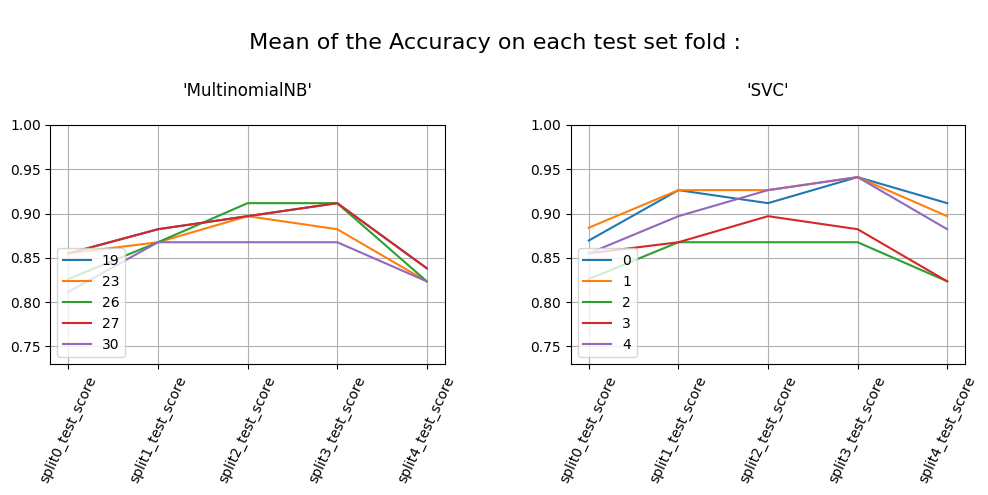

In [ ]:
#YOUR CODE STARTS HERE#

fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("\n Mean of the Accuracy on each test set fold : \n", fontsize=16)
names = ["'MultinomialNB'", "'SVC'"]

for i in range(2):
    axarr[i].plot(other_list[i],  label=other_list[i].columns)
    axarr[i].set_title(names[i]+"\n")
    axarr[i].grid()
    axarr[i].tick_params(axis='x', rotation=65)
    axarr[i].legend(loc="lower left"); axarr[i].set_ylim([0.73, 1])

fig.tight_layout(); fig.subplots_adjust(top=0.75, wspace=0.32); plt.show(); print()

#s =  results[["mean_fit_time", "mean_test_score"]].T
#poi = [s[this_list[0].index[:5]], s[this_list[1].index[:5]]]; display(poi[0], poi[1])

#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

For each plot produced, which combination of hyper-parameters would you select?

**Use at most 2 sentences (per plot).**

[comment]: <> (#SHOW_CELL#)

----------YOUR TEXT STARTS HERE----------

<br>

Since all configurations are similar and also their performances,\
I would choose the algorithm with least time in testing, according to `mean_fit_time` (also accepting slightly less accuracy)


- **SVC** → configuration index $0$ (fastest and also best performance)
- **MultinomialNB** → configuration index $26$ (mean accuracy = 0.87)





<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.8
For each of the optimisations, obtain a classifier using the parameters you selected in step 2.1.6.

In [ ]:
#YOUR CODE STARTS HERE#

## pipeline of best estimator with best config :
pip = gs.best_estimator_
pip.verbose=False

## second model :
if type(gs.best_estimator_["clf"]) == type(my_algorithms_list[0]()):
    parametri = df_alg_2.iloc[0].to_dict()
    model_2 = my_algorithms_list[1]
    
elif type(gs.best_estimator_["clf"]) == type(my_algorithms_list[1]()):
    parametri = df_alg_1.iloc[0].to_dict()
    model_2 = my_algorithms_list[0]

p1 = {x.split("__")[-1]:parametri[x] for x in parametri if x.startswith("vect")}
p2 = {x.split("__")[-1]:parametri[x] for x in parametri if x.startswith("clf")} 

pipe_2 = Pipeline([('vect', TfidfVectorizer(lowercase=False, **p1)), ("clf", model_2(**p2))]) 
pipe_2.verbose=False
pipeline_list = [pip, pipe_2]

print("\n optimized : {}\n".format(my_algorithms_list[0]())); display(pipeline_list[0])
print("-"*60)
print("\n optimized : {}\n".format(my_algorithms_list[1]())); display(pipeline_list[1])



#YOUR CODE ENDS HERE#
#THIS IS LINE 30#


 optimized : MultinomialNB()



Pipeline(steps=[('vect',
                 TfidfVectorizer(lowercase=False, max_df=0.8,
                                 tokenizer=<function stm_stp_tknz at 0x7fd3abb68b80>)),
                ('clf', SVC(C=0.99, kernel='linear', random_state=160))])

------------------------------------------------------------

 optimized : SVC()



Pipeline(steps=[('vect',
                 TfidfVectorizer(lowercase=False, max_df=0.8,
                                 tokenizer=<function stm_stp_tknz at 0x7fd3abb68b80>)),
                ('clf', MultinomialNB(alpha=0.15, class_prior=(0.5, 0.5)))])

Apply the classifier(s) to obtain the confusion matrix on the test data and print it out.

[comment]: <> (#SHOW_CELL#)

In [ ]:
#YOUR CODE STARTS HERE#
confusion_list, names = [], []
print("\nConfusion Matrix: True-Classes X Predicted-Classes\n\n")

for pipe in pipeline_list:
    pipe.fit(x_train, y_train); pred_test_y = pipe.predict(x_val)
    confusion_matrix_df = pd.DataFrame(metrics.confusion_matrix(y_val, pred_test_y))
    confusion_list.append((confusion_matrix_df)); names.append(str(pipe.named_steps["clf"]))

spaces = [tabulate(element, headers="keys").split("\n") for element in confusion_list]
double_table = ''.join([("\t"+x+" \t\t\t "+y+"\n") for x,y in zip(spaces[0],spaces[1])])
print("\t{} \t\t\t {}\n\n {}".format(names[0].split('(')[0], names[1].split('(')[0], double_table))

#YOUR CODE ENDS HERE#
#THIS IS LINE 15#


Confusion Matrix: True-Classes X Predicted-Classes


	SVC 			 MultinomialNB

 	      0    1 			       0    1
	--  ---  --- 			 --  ---  ---
	 0   34    7 			  0   35    6
	 1    1   44 			  1    3   42



<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

## Part 2.2

### 2.2.1
You have a training set containing N documents. There are $M_1$ unique terms within the dataset.

The test dataset will have $M_2$ unique terms within it. However, we know that only a small amount of these will be in common with the training dataset.

What precautions could we use to preprocess the data?

What could we change at test time and which of the classification algorithms seen in class would best suit the change?

**Use at most 4 sentences.**

----------YOUR TEXT STARTS HERE----------

<br>

I would use complete preprocessing (**stemming** and **stop words removal**)\.

Then increase the considered `vect__ngram_range` step to (2,2 → only bigrams) or (2,3)\
and choose a `vect_min_df` higher than deafault to discard tokens that appear less frequently than the treshold

At testing time I would look at a more comprehensive metric then accuracy, such as the F1 score.

As algorithm SVC is effective for high dimensional data and can handle sparse feature vectors

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>


# Submission instructions

Follow the instructions precisely
1. Run the whole notebook up to this point
  * Click on this text cell and go to Runtime > Run before
  * It is essential that the notebook can be run from start to finish without us having to change anything.
2. Download the current notebook
  * File -> Download -> Download .ipynb
3. Upload the downloaded notebook in the current runtime
  * In the left sidebar menu, open the last tab (Files)
  * Click on the first button under the File title (Page with arrow pointing up)
  * In the new window, upload the notebook just downloaded



4. To turn the notebook into a pdf you need to install a Tex extension: run the next cell of code:

In [ ]:
#REMOVE_CELL#
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-plain-generic is already the newest version (2019.202000218-1).
texlive-xetex is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


5. Now, run the next cell to set some cell tags in the notebook file.

In [ ]:
#REMOVE_CELL#

import nbformat as nbf
from glob import glob

notebooks = glob("/content/**/*.ipynb", recursive=True)

text_search_dict = ["YOUR TEXT STARTS HERE","#YOUR CODE STARTS HERE#"]

for ipath in notebooks:
    print(ipath)
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)

    for cell in ntbk.cells:
        cell_type = cell['cell_type'] == "code"
      
        cell_tags = cell.get('metadata', {}).get('tags', [])
        cell_tags = set(cell_tags)

        if cell_type == 0: #markdown
          if (cell['source'][0]!="#" and text_search_dict[cell_type] not in cell['source'] and "pagebreak" not in cell['source']) or "#REMOVE_CELL#" in cell['source']:
            cell_tags.add("remove_cell")

        else: #code
          #if text_search_dict[cell_type] not in cell['source'] or "#REMOVE_CELL#" in cell['source']:
          if "#REMOVE_CELL#" in cell['source']:
            cell_tags.add("remove_cell")
          elif "#REMOVE_OUTPUT#" in cell['source']:
            cell_tags.add("remove_output")
        
        if len(cell_tags) > 0:
            cell['metadata']['tags'] = list(cell_tags)

    nbf.write(ntbk, ipath)

/content/DMT2023_HW3.ipynb


6. Now, run the next cell to transform the notebook to PDF without the code cells.
  * The file will appear in the menu on the left (refresh if needed). The file should be named `DMT2023_HW3.pdf`
  * Rename this file **Surname1_Surname2_DMT2023_HW3_report.pdf** (e.g. Becchetti_Siciliano_DMT2023_HW3_report.pdf). Sort the surnames alphabetically.
  * Click on it and using the right button or the three dots at its side, click on download to transfer it to your local PC
  

In [ ]:
#REMOVE_CELL#
!jupyter nbconvert /content/DMT2023_HW3.ipynb --to pdf --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' -TagRemovePreprocessor.remove_all_outputs_tags='{"remove_output"}'

7. Now, rename the downloaded notebook **Surname1_Surname2_DMT2023_HW3_notebook.ipynb** (e.g. Becchetti_Siciliano_DMT2023_HW3_notebook.ipynb). Sort the surnames alphabetically.

8. Now that you have both files, you need to upload them to Classroom. Only the student with the surname that comes first in alphabetical order **must** upload the files. Only the files uploaded by this student will be graded.